## 특정 영역(독도 반경 50km)의 생물종 증감률 분석     
2018년 말을 기준으로 이전 3년(2016~2018)과 이후 3년(2019~2021)간의     
수온 및 생물종 증감률 분석을 통해 변화 특성을 찾기  

### 필요한 패키지(모듈/라이브러리) 준비

In [1]:
import os
import pandas as pd  #2차원 표 형태의 데이터프레임 처리용 패키지
import geopandas as gpd  #pandas를 기반으로 벡터 지오메트리(점/선/면)를 포함한 GeoDataFrame을 처리하는 패키지
from shapely.geometry import Point, Polygon #점, 선, 면 Geometry 처리용 패키지 
pd.set_option('float_format', '{:f}'.format)  # 숫자가 지수 형태로 표시되지 않도록 

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px #차트 시각화 패키지 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid') #whitegrid, dark, white, ticks
mpl.rc('font', family='Malgun Gothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (10, 10) #차트 사이즈

#### 시공간 정보가 포함된 해양생물종 데이터(OBIS) 로딩 및 전처리

In [3]:
gdf_pt = gpd.read_file('../data/geo_mbris_obis_edu_light.gpkg', encoding="UTF-8")
gdf_pt.info()
gdf_pt.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 220833 entries, 0 to 220832
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   spc_scitf_nm  220833 non-null  object  
 1   comm_kor_nm   163598 non-null  object  
 2   genus         220681 non-null  object  
 3   genus_nm      164667 non-null  object  
 4   family        220727 non-null  object  
 5   family_nm     163772 non-null  object  
 6   order_        220742 non-null  object  
 7   order_nm      162672 non-null  object  
 8   class         220809 non-null  object  
 9   class_nm      171786 non-null  object  
 10  phylum        220811 non-null  object  
 11  phylum_nm     206406 non-null  object  
 12  kingdom       220833 non-null  object  
 13  kingdom_nm    220833 non-null  object  
 14  lati_val      220833 non-null  float64 
 15  loti_val      220833 non-null  float64 
 16  col_bg_dt     220833 non-null  object  
 17  ssea_id       220833 

spc_scitf_nm comm_kor_nm           genus genus_nm  \
0     Mucor circinelloides        None           Mucor     None   
1  Paralinhomoeus gerlachi        None  Paralinhomoeus     None   
2          Aplysia kurodai          군소         Aplysia      군소속   
3         Botrytis cinerea        None        Botrytis     None   
4              Trichoderma        None     Trichoderma     None   

            family family_nm        order_ order_nm            class class_nm  \
0       Mucoraceae      None     Mucorales     None    Mucoromycetes     None   
1     Linhomoeidae      None  Monhysterida     None      Chromadorea     None   
2       Aplysiidae       군소과     Aplysiida     None       Gastropoda      복족강   
3  Sclerotiniaceae      None    Helotiales     None    Leotiomycetes     None   
4     Hypocreaceae      None   Hypocreales     None  Sordariomycetes     None   

   ... phylum_nm   kingdom kingdom_nm  lati_val   loti_val  col_bg_dt ssea_id  \
0  ...      None     Fungi         균계 38.481861 128.438194   20160802      EM   
1  ...     선형동물문  Animalia        동물계 38.269869 128.557564   20160415      EM   
2  ...     연체동물문  Animalia        동물계 38.271903 128.558261   20190522      EM   
3  ...      None     Fungi         균계 38.153361 128.608306   19000100      EM   
4  ...      None     Fungi         균계 37.858556 128.854389   20160926      EM   

  sstrnc_no   kind                    geometry  
0    5055-3  mbris  POINT (128.43819 38.48186)  
1      55-4  mbris  POINT (128.55756 38.26987)  
2      55-4  mbris  POINT (128.55826 38.27190)  
3      55-7  mbris  POINT (128.60831 38.15336)  
4      62-3  mbris  POINT (128.85439 37.85856)  

[5 rows x 21 columns]

In [4]:
#시간 열을 datetime 형식으로 변환 
#errors = 'coerce' 문자가 포함되어 있는 경우, 강제로 'NaN'으로 변환하고, 나머지 숫자로된 문자열은 숫자형으로 변환
gdf_pt['col_bg_dt2']  = pd.to_datetime(gdf_pt['col_bg_dt'] , format='%Y%m%d', errors='coerce')

In [5]:
# col_bg_dt2가 null인 데이터는 삭제 
gdf_pt.dropna(subset=['col_bg_dt2'], inplace=True)
gdf_pt.shape

(220498, 22)

#### 공간 영역 설정

https://www.openstreetmap.org/ 에 접속해서 '독도'를 검색하고, 울릉군 독도리에 해당하는 독도를 클릭하면 해당 위치로 지도가 표시됨     
지도의 독도 상에서 컨텍스트 메뉴의 "여기를 가운데로 지정"를 선택하면, 독도에 대한 좌표가 URL에 보임     
https://www.openstreetmap.org/relation/6646538#map=16/37.2422/131.8669   

또는 epsg.io.map에 접속해도 쉽게 좌표를 확인할 수 있음    
https://epsg.io/map#srs=4326&x=131.866279&y=37.241672&z=15&layer=streets   
131.866279 37.241672

In [6]:
# 특정 위도, 경도 및 버퍼 거리를 설정합니다.
longitude = 131.866279
latitude = 37.241672
buffer_distance = 50000   #50킬로미터  
geom_latlon = Point(longitude, latitude)                # 경위도 Point Geometry를 생성
gdf_pt4326 = gpd.GeoDataFrame(geometry=[geom_latlon], crs='epsg:4326' ) # 경위도 Point GeoDataFrame을 생성
gdf_pt3857 = gdf_pt4326.to_crs(epsg=3857)               # Point GeoDataFrame을 평면직각좌표계(3857)로 변환
geom_buf = gdf_pt3857.geometry.buffer(buffer_distance)  # gdf_pt3857에 대한 버퍼 공간데이터를 생성 
gdf_buf3857 = gpd.GeoDataFrame(geometry=geom_buf )      # 버퍼 폴리곤을 GeoDataFrame으로 변환
gdf_buf4326 = gdf_buf3857.to_crs(epsg=4326)             # 버퍼 폴리곤을 4326으로 변환 (생물종과 공간조인을 위해)

In [7]:
gdf_buf4326.explore()

In [8]:
# 생물종 데이터에서 반경 영역에 해당하는 데이터만 추출 
gdf_pt2 = gpd.sjoin(gdf_pt, gdf_buf4326, how='inner', predicate='intersects', lsuffix='left' ).reset_index()
gdf_pt2.info()
gdf_pt2.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         3354 non-null   int64         
 1   spc_scitf_nm  3354 non-null   object        
 2   comm_kor_nm   2839 non-null   object        
 3   genus         3337 non-null   object        
 4   genus_nm      2678 non-null   object        
 5   family        3341 non-null   object        
 6   family_nm     2864 non-null   object        
 7   order_        3341 non-null   object        
 8   order_nm      2836 non-null   object        
 9   class         3354 non-null   object        
 10  class_nm      2854 non-null   object        
 11  phylum        3354 non-null   object        
 12  phylum_nm     3086 non-null   object        
 13  kingdom       3354 non-null   object        
 14  kingdom_nm    3354 non-null   object        
 15  lati_val      3354 non-null   

index       spc_scitf_nm comm_kor_nm     genus genus_nm       family  \
0  136375   Bacillus pumilus        None  Bacillus     None  Bacillaceae   
1  136376  Bacillus subtilis        None  Bacillus     None  Bacillaceae   
2  180248      Iso flosmaris         물꽃치       Iso     물꽃치속     Isonidae   
3  180249      Iso flosmaris         물꽃치       Iso     물꽃치속     Isonidae   
4  180250      Iso flosmaris         물꽃치       Iso     물꽃치속     Isonidae   

  family_nm          order_ order_nm           class  ... kingdom_nm  \
0      None   Caryophanales     None         Bacilli  ...        세균계   
1      None   Caryophanales     None         Bacilli  ...        세균계   
2      물꽃치과  Atheriniformes     색줄멸목  Actinopterygii  ...        동물계   
3      물꽃치과  Atheriniformes     색줄멸목  Actinopterygii  ...        동물계   
4      물꽃치과  Atheriniformes     색줄멸목  Actinopterygii  ...        동물계   

   lati_val   loti_val col_bg_dt ssea_id  sstrnc_no   kind  \
0 37.239722 131.867222  20080413      EM       74-6  mbris   
1 37.239722 131.867222  20080413      EM       74-6  mbris   
2 37.148650 131.816169  20140722      EM       74-8  mbris   
3 37.148650 131.816169  20140723      EM       74-8  mbris   
4 37.154533 131.804667  20140723      EM       74-8  mbris   

                     geometry col_bg_dt2 index_right  
0  POINT (131.86722 37.23972) 2008-04-13           0  
1  POINT (131.86722 37.23972) 2008-04-13           0  
2  POINT (131.81617 37.14865) 2014-07-22           0  
3  POINT (131.81617 37.14865) 2014-07-23           0  
4  POINT (131.80467 37.15453) 2014-07-23           0  

[5 rows x 24 columns]

#### 기준 시점 및 기간 설정

증감률 = [(기준시점 이후의 측정값 - 기준시점 이전의 측정값) ÷ 기준시점 이전의 측정값] × 100    
증감률이 100이면 2배 증가한 것 

In [9]:
# 기간을 설정합니다.
base_date = pd.to_datetime('2018-12-31')
period_before = (gdf_pt2['col_bg_dt2'] > base_date - pd.DateOffset(years=3)) & (gdf_pt2['col_bg_dt2'] <= base_date)
period_after = (gdf_pt2['col_bg_dt2'] > base_date) & (gdf_pt2['col_bg_dt2'] <= base_date + pd.DateOffset(years=3))

# 각 기간에 대해 목 단위('order_nm') 유형별 개수를 계산합니다.
order_counts_before = gdf_pt2.loc[period_before, 'order_nm'].value_counts()
order_counts_after = gdf_pt2.loc[period_after, 'order_nm'].value_counts()

# 증감률을 계산합니다. 불완전한 데이터로 인해 분모가 0이 될 수 있으므로, 이를 처리하기 위해 'divide' 함수를 사용합니다.
growth_rate = order_counts_after.divide(order_counts_before).subtract(1).multiply(100).reset_index()
growth_rate.info()
growth_rate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   order_nm  72 non-null     object 
 1   count     39 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB


order_nm      count
0     가리비목        NaN
1     각산호목        NaN
2  갈고리노벌레목        NaN
3    갈고리풀목 -88.888889
4     갈파래목 -50.000000

In [10]:
# 증감률이 null인 데이터는 삭제 
growth_rate.dropna(subset=['count'], inplace=True)

In [11]:
# 증감률이 높은 순서대로 정렬
growth_rate_sort = growth_rate.sort_values(by='count', ascending=False)
#growth_rate_sort.index=growth_rate_sort.name
growth_rate_sort.head()

order_nm      count
53       십각목 428.571429
16  꽃민컵히드라충목 300.000000
31      돌산호목 266.666667
61       차극목 200.000000
62      채찍말목 150.000000

In [24]:
# Plotly 막대 차트를 그립니다.
fig = px.bar(growth_rate_sort, x='order_nm', y='count', title='2016~2018년 대비 2019~2021년 독도 반경 50km의 목 단위별 증감률')

# x축과 y축의 제목을 설정합니다.
fig.update_layout(
    xaxis_title="목",
    yaxis_title="증감률",
)

fig.show()

### 독도 생물종 지도 시각화

In [13]:
# datetime64 형식이 folium에서 처리가 안되는 문제가 있어서 제거하고 지도 표시 
gdf_pt3 = gdf_pt2.copy()
# gdf_pt3.dropna(subset=['col_bg_dt2'], inplace=True)
del gdf_pt3['col_bg_dt2']
gdf_pt3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         3354 non-null   int64   
 1   spc_scitf_nm  3354 non-null   object  
 2   comm_kor_nm   2839 non-null   object  
 3   genus         3337 non-null   object  
 4   genus_nm      2678 non-null   object  
 5   family        3341 non-null   object  
 6   family_nm     2864 non-null   object  
 7   order_        3341 non-null   object  
 8   order_nm      2836 non-null   object  
 9   class         3354 non-null   object  
 10  class_nm      2854 non-null   object  
 11  phylum        3354 non-null   object  
 12  phylum_nm     3086 non-null   object  
 13  kingdom       3354 non-null   object  
 14  kingdom_nm    3354 non-null   object  
 15  lati_val      3354 non-null   float64 
 16  loti_val      3354 non-null   float64 
 17  col_bg_dt     3354 non-null   object  
 18  

In [14]:
# 전체 데이터의 목 단위 범주시각화 
gdf_pt3.explore('order_nm',categorical=True, tiles='http://xdworld.vworld.kr:8080/2d/Satellite/service/{z}/{x}/{y}.jpeg', attr='브이월드')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



## 목별 단계구분도 공간시각화

In [15]:
# 증감률 중에서 증가율이 100 이상인 것만 추출
growth_rate2 = growth_rate[ growth_rate['count'] >= 100  ]

In [16]:
gdf_pt4 = pd.merge(gdf_pt3, growth_rate2, on='order_nm', how='right')
gdf_pt4.head()

index          spc_scitf_nm comm_kor_nm         genus genus_nm  \
0  184186  Dichotomaria falcata    여린두가닥바닷말  Dichotomaria  두가닥바닷말속   
1  184187  Dichotomaria falcata    여린두가닥바닷말  Dichotomaria  두가닥바닷말속   
2  184188  Dichotomaria falcata    여린두가닥바닷말  Dichotomaria  두가닥바닷말속   
3  184526   Scinaia johnstoniae       탕건흐늘풀       Scinaia     흐늘풀속   
4  184665   Otohimella japonica      외분홍국수말    Otohimella     None   

          family family_nm      order_ order_nm            class  ...  \
0  Galaxauraceae     가위손말과  Nemaliales    국수나물목  Florideophyceae  ...   
1  Galaxauraceae     가위손말과  Nemaliales    국수나물목  Florideophyceae  ...   
2  Galaxauraceae     가위손말과  Nemaliales    국수나물목  Florideophyceae  ...   
3    Scinaiaceae      흐늘풀과  Nemaliales    국수나물목  Florideophyceae  ...   
4    Liagoraceae    분홍국수말과  Nemaliales    국수나물목  Florideophyceae  ...   

  kingdom_nm  lati_val   loti_val col_bg_dt ssea_id  sstrnc_no   kind  \
0        식물계 37.239508 131.867728  20180512      EM       74-6  mbris   
1        식물계 37.239508 131.867728  20180512      EM       74-6  mbris   
2        식물계 37.239508 131.867728  20180512      EM       74-6  mbris   
3        식물계 37.239583 131.871914  20180511      EM       74-6  mbris   
4        식물계 37.239589 131.867833  20200825      EM       74-6  mbris   

                     geometry index_right      count  
0  POINT (131.86773 37.23951)           0 100.000000  
1  POINT (131.86773 37.23951)           0 100.000000  
2  POINT (131.86773 37.23951)           0 100.000000  
3  POINT (131.87191 37.23958)           0 100.000000  
4  POINT (131.86783 37.23959)           0 100.000000  

[5 rows x 24 columns]

In [17]:
import contextily as ctx

In [18]:
gdf_pt4.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
gdf_pt3_3857 = gdf_pt3.to_crs(3857)
gdf_pt4_3857 = gdf_pt4.to_crs(3857)

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:732: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



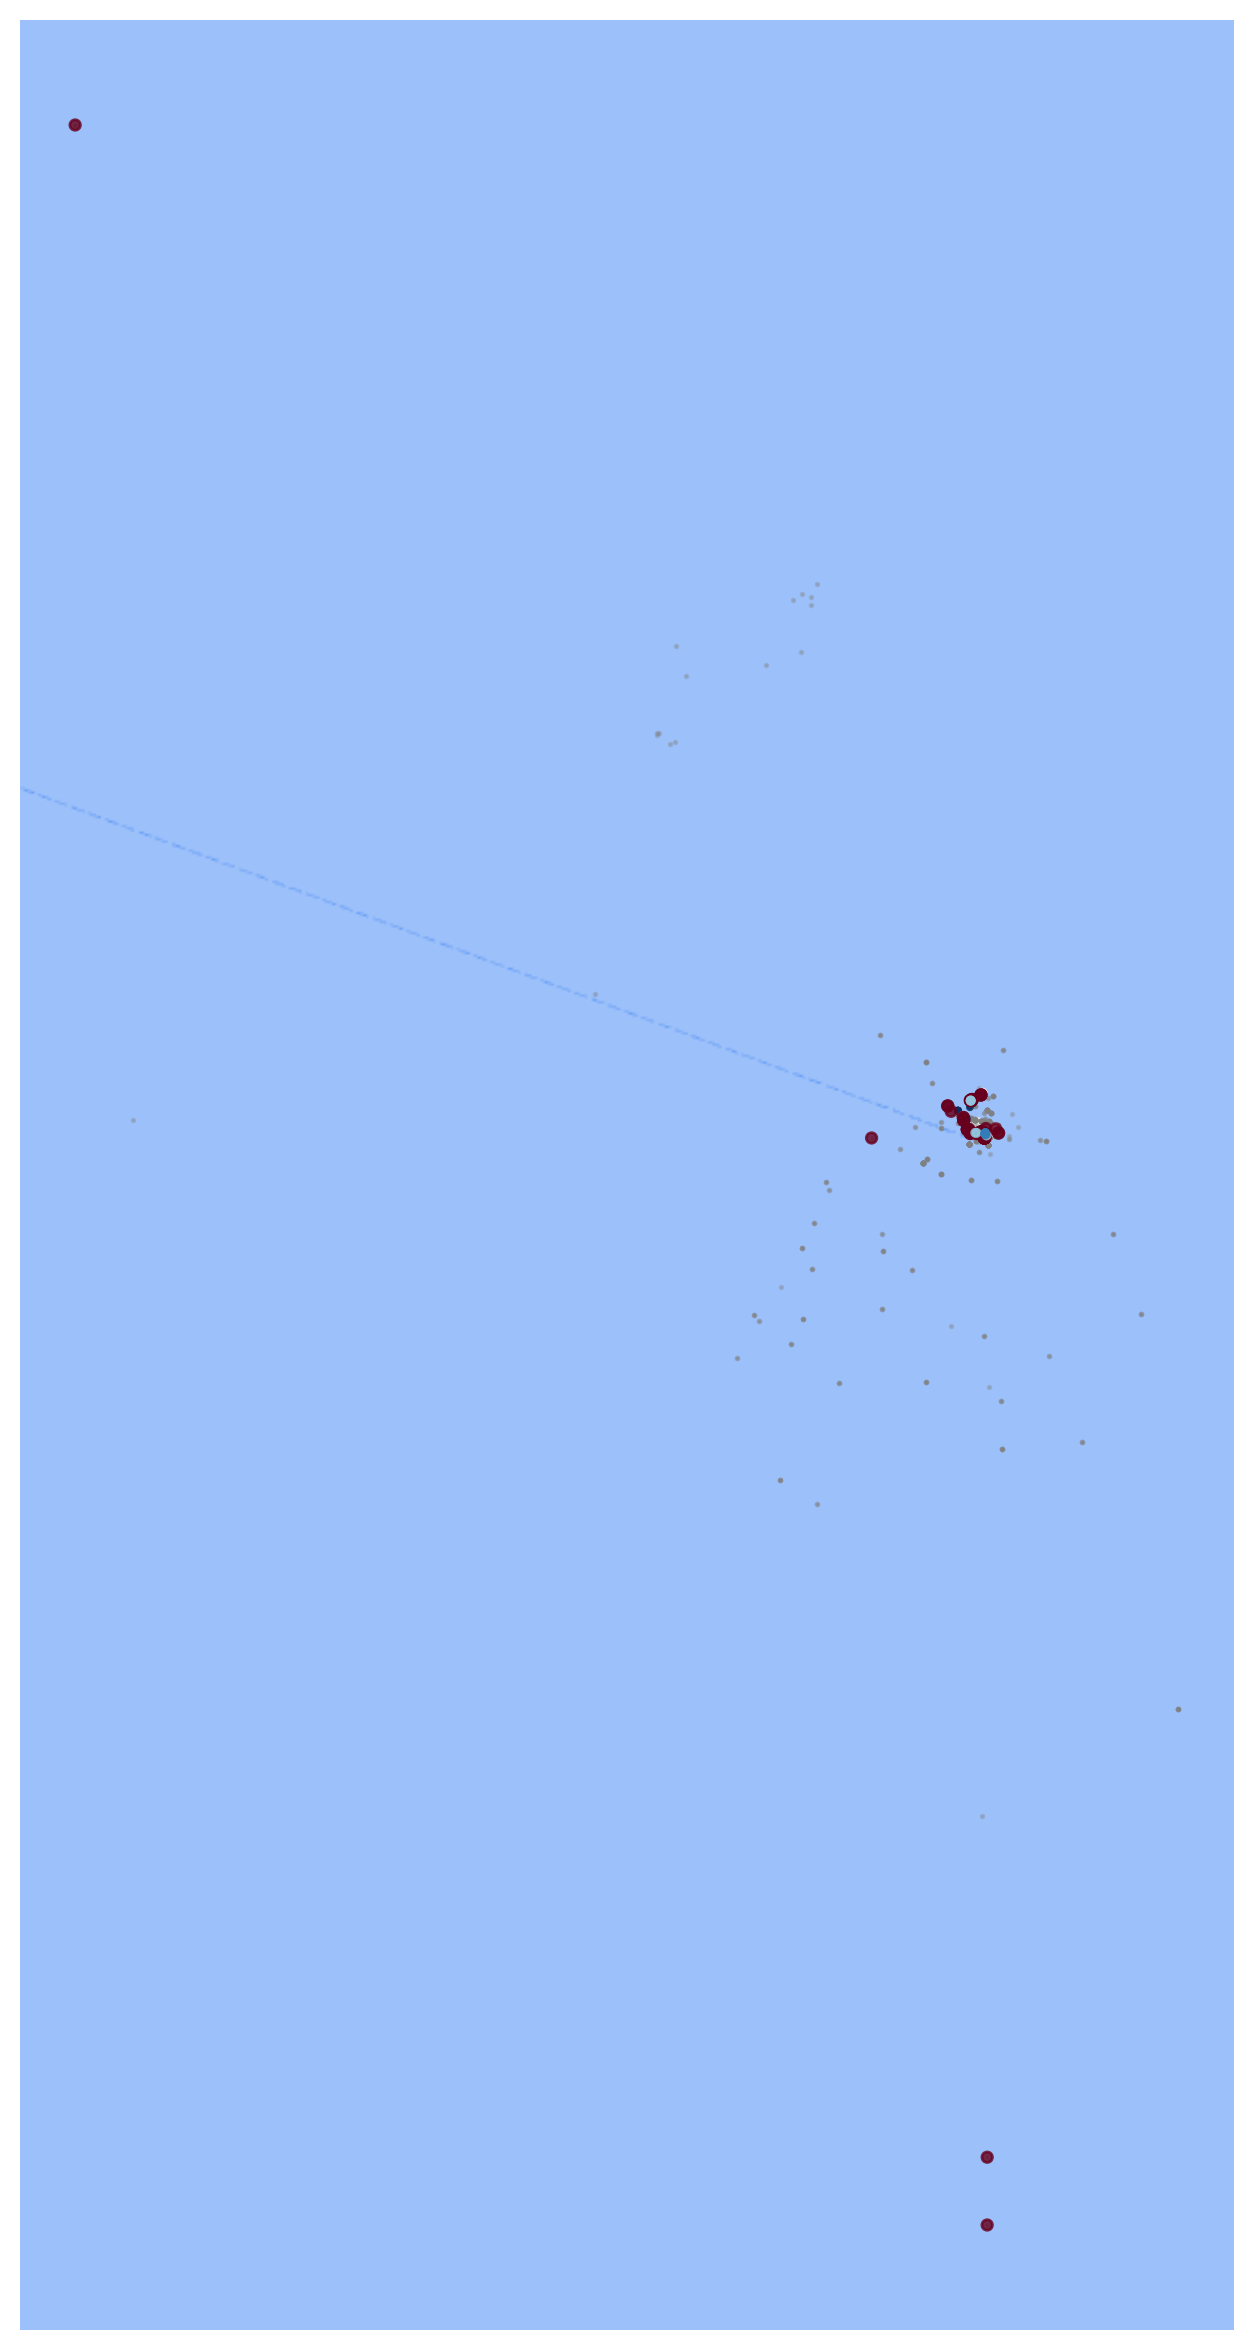

In [20]:
# 단계구분도 시각화
ax = gdf_pt3_3857.plot(markersize=1, color='gray', figsize=(20, 15), alpha=0.3)   
gdf_pt4_3857.plot(column='count', cmap='RdBu_r', alpha=0.8, markersize=gdf_pt4_3857['count']/30, ax = ax)
ctx.add_basemap(ax, source='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}' )  #'http://xdworld.vworld.kr:8080/2d/gray/service/{z}/{x}/{y}.png'
ax.set_axis_off()
plt.show()

In [21]:
# 단계구분도 시각화2
# gdf_pt4.explore('count',categorical=False, tiles='http://xdworld.vworld.kr:8080/2d/midnight/service/{z}/{x}/{y}.png', attr='브이월드')
gdf_pt4.explore(column='count', marker_kwds={'radius': 10}, cmap='RdBu_r', tiles='http://xdworld.vworld.kr:8080/2d/midnight/service/{z}/{x}/{y}.png', attr='브이월드')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:732: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



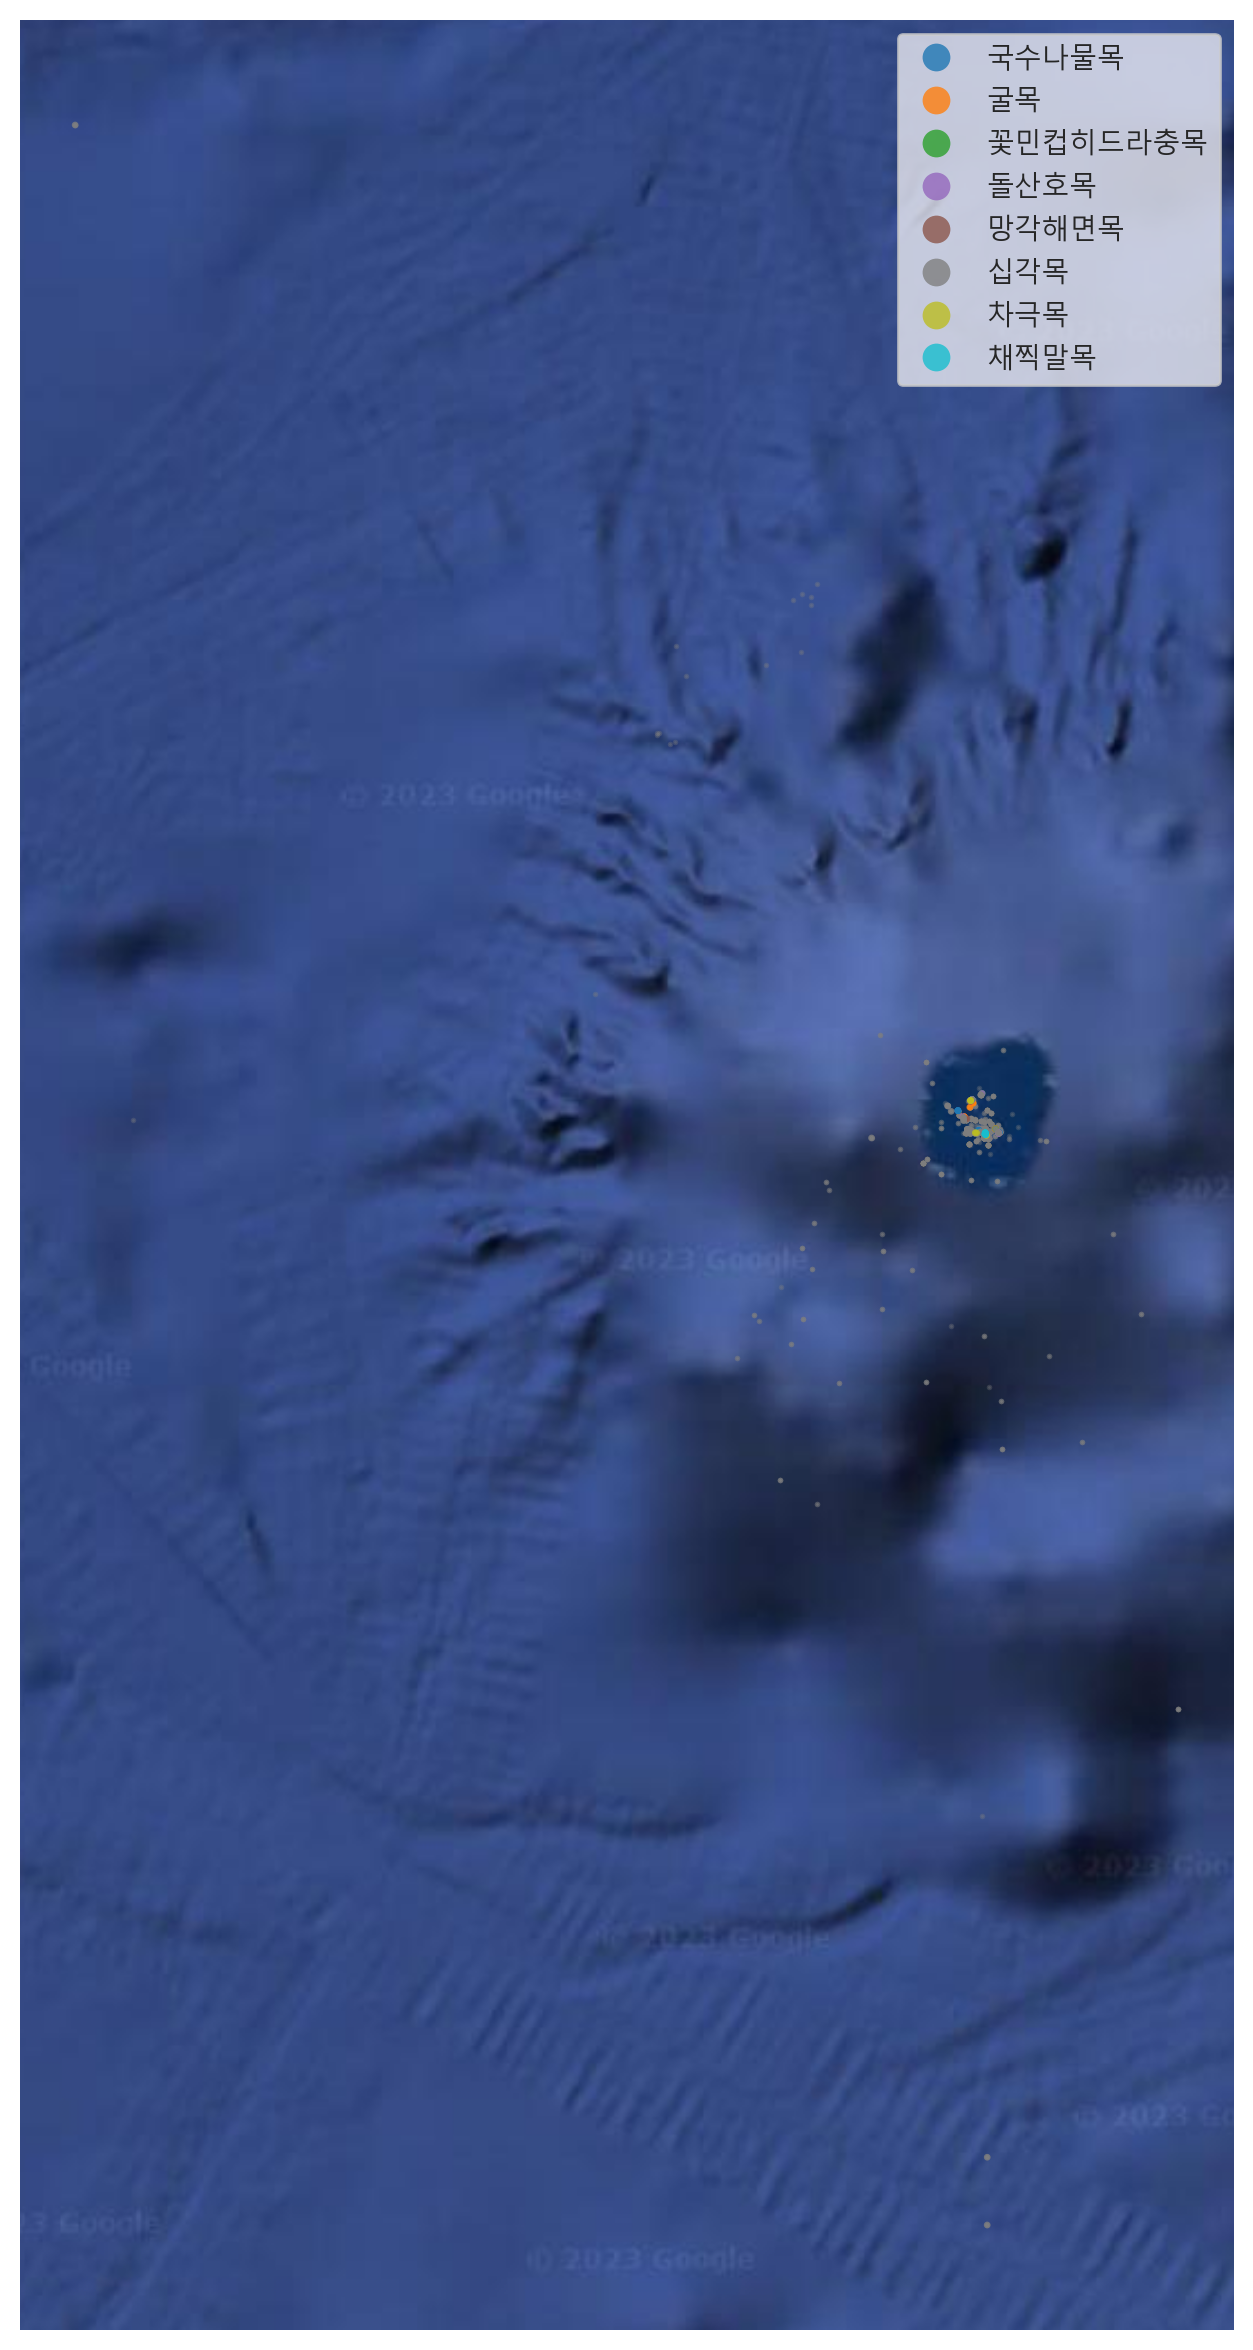

In [22]:
# 범주형 시각화2
ax = gdf_pt3_3857.plot(markersize=1, color='gray', figsize=(20, 15), alpha=0.3)   
# gdf_pt4_3857.plot(column='count', cmap='RdBu_r', alpha=0.8, markersize =2, ax = ax)
# 'order_nm',categorical=True
gdf_pt4_3857.plot('order_nm', categorical=True, markersize =2, alpha=0.8, legend=True, ax = ax)
ctx.add_basemap(ax, source="http://mt0.google.com/vt/lyrs=s&hl=ko&x={x}&y={y}&z={z}")  #ctx.sources.ST_TONER_LITE
ax.set_axis_off()
plt.show()

In [23]:
# 동적 목 단위 범주시각화 - 지도를 확대해 보세요 
# gdf_pt4.explore('order_nm',categorical=True, tiles='http://xdworld.vworld.kr:8080/2d/Satellite/service/{z}/{x}/{y}.jpeg', attr='브이월드')
gdf_pt4.explore('order_nm',categorical=True, tiles='http://xdworld.vworld.kr:8080/2d/midnight/service/{z}/{x}/{y}.png', attr='브이월드')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

